In [1]:
'''
NOTE: Requires latest version of Jax - previous versions (before 06/20)
don't have pathwise implicit derivatives for gamma/dirichlet nor
derivatives of digamma/polygamma function.
'''
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.ops import index, index_add, index_update
import jax.scipy.special as sc
from jax.flatten_util import ravel_pytree
import jax

In [2]:
import matplotlib.pyplot as plt
import dill
import types
import warnings
from copy import deepcopy
from tqdm.notebook import tqdm

In [3]:
key = random.PRNGKey(41310)
key

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([    0, 41310], dtype=uint32)

In [4]:
# Load defined models and trajectories
'''
These are synthetics examples for an optimal stopping problem for
clinician diagnosis of disease
'''
with open('data/model0.obj', 'rb') as f:
    model = dill.load(f)
with open('data/model0_trajs.obj', 'rb') as f:
    trajs_raw = dill.load(f)


In [5]:
A = model.A
S = model.S
Z = model.Z

In [6]:
import numpy as onp
n = len(trajs_raw)
taus = onp.zeros(n, dtype='int')
for i in range(n):
    taus[i] = trajs_raw[i].tau
tau = taus.max()

trajs = onp.ones((n,2,tau),dtype=int) * A
trajs[:,1,:] = onp.zeros((n,tau),dtype=int)
for i in range(n):
    trajs[i][0,:trajs_raw[i].tau] = onp.array(trajs_raw[i].a)
    trajs[i][1,:trajs_raw[i].tau] = onp.array(trajs_raw[i].z)
trajs = np.array(trajs)

In [8]:
'''
Initialise parameters phi
'''
b0_p = np.ones((S)) * 30
T_p  = np.ones((S,A,S)) * 30
O_p  = np.ones((A,S,Z)) * 30

mu_p = np.ones((A,S,2))
mu_p = index_update(mu_p,index[:,:,1],np.ones((A,S))*0.6)
eta_p = np.ones(2)


In [9]:
'''
Setting the priors over the parameters
'''
b0_prior = np.ones((S)) * 3
T_prior  = np.ones((S,A,S)) * 3
O_prior  = np.ones((A,S,Z)) * 3

mu_prior = np.ones((A,S,2))
mu_prior = index_update(mu_prior,index[:,:,1],np.ones((A,S))*0.6)
eta_prior = np.ones(2)


In [10]:
'''
Define mean vector policy parameterisation
'''
@jit
def policy(mu,eta,b):
    del_a = np.exp(-eta*np.sum((b-mu)**2,axis=-1))
    del_a /= del_a.sum()
    return del_a

@jit
def keep_pos(x):
    return np.log(1+np.exp(x))

In [11]:
'''
Sample some inital values
'''
key,*subkeys = random.split(key,6)

b0 = random.dirichlet(subkeys[0],b0_p)
T  = random.dirichlet(subkeys[1],T_p)
O  = random.dirichlet(subkeys[2],O_p)

mu = (random.normal(subkeys[3],shape=(A,S)) * mu_p[:,:,1]) + mu_p[:,:,0]
eta = random.gamma(subkeys[4],eta_p[0])*eta_p[1]

In [12]:
'''
KL diveregences for all of the parameters
'''

@jit
def KL_eta(q,p):
    
    KL = (q[0]*np.log(q[1])) - (p[0]* np.log(p[1])) - \
            sc.gammaln(q[0]) + sc.gammaln(p[0]) + \
            (q[0]-p[0])*(sc.digamma(q[0])-np.log(q[1])) - \
            q[0] * (1 - (p[1]/q[1]))
    
    return KL

@jit
def KL_mu(q,p):
    
    s1 = keep_pos(q[:,:,1])
    s2 = keep_pos(p[:,:,1])
    KL = np.log(s2) - np.log(s1) + \
        (((s1**2) + ((q[:,:,0] - p[:,:,0])**2)) / \
        (2*(s2**2))) - 0.5
    return KL

@jit
def KL_O(q,p):
    
    KL = sc.gammaln(q.sum(axis=2)) - sc.gammaln(p.sum(axis=2)) - \
            (sc.gammaln(q) - sc.gammaln(p) - ((q-p) * (sc.digamma(q) - \
            sc.digamma(q.sum(axis=2)).reshape((A,S,1))))).sum(axis=2)
    
    return KL

@jit
def KL_T(q,p):
    
    KL = sc.gammaln(q.sum(axis=2)) - sc.gammaln(p.sum(axis=2)) - \
            (sc.gammaln(q) - sc.gammaln(p) - ((q-p) * (sc.digamma(q) - \
            sc.digamma(q.sum(axis=2)).reshape((S,A,1))))).sum(axis=2)
    
    return KL

@jit
def KL_b0(q,p):
    
    KL = sc.gammaln(q.sum()) - sc.gammaln(p.sum()) - \
            (sc.gammaln(q) - sc.gammaln(p) - ((q-p) * (sc.digamma(q) - \
            sc.digamma(q.sum())))).sum()
    
    return KL

In [13]:
'''
Returns exponent of expected log values (not standard expected value)
'''
@jit
def get_exp_T(x):
    
    return np.exp(jax.scipy.special.digamma(x) - \
                  jax.scipy.special.digamma(np.sum(x,axis=2)).reshape((S,A,1)))

@jit
def get_exp_O(x):
    
    return np.exp(jax.scipy.special.digamma(x) - \
                  jax.scipy.special.digamma(np.sum(x,axis=2)).reshape((A,S,1)))

@jit
def get_exp_b0(x):
    
    return np.exp(jax.scipy.special.digamma(x) - \
                  jax.scipy.special.digamma(np.sum(x)))

@jit
def get_theta_hat(b0,O,T):
    
    b0_hat = get_exp_b0(b0)
    O_hat = get_exp_O(O)
    O_hat = np.concatenate((O_hat, np.ones((S,Z))[None,:,:]), axis=0)
    T_hat = get_exp_T(T)
    T_hat = np.concatenate((T_hat, np.eye(S)[:,None,:]), axis=1)
    
    return (b0_hat,O_hat,T_hat)
    

In [14]:
theta_hat = get_theta_hat(b0_p,O_p,T_p)

In [15]:
@jit
def compute_messages(theta_hat, traj):
    b0,O,T = theta_hat
    
    alp = [None] * (tau+1)
    alp[0] = b0
    for t in range(tau):
        alp[t+1] = np.ravel(O[traj[0,t],:,traj[1,t],None] * T[:,traj[0,t],:].T @ alp[t][:,None])
        alp[t+1] = alp[t+1] / alp[t+1].sum()
    bet = [None] * (tau+1)
    bet[-1] = np.ones(S)
    for t in reversed(range(tau)):
        bet[t] = np.ravel(T[:,traj[0,t],:] @ (O[traj[0,t],:,traj[1,t],None] * bet[t+1][:,None]))
        bet[t] = bet[t] / bet[t].sum()
    gmm = [None] * (tau+1)
    for t in range(tau+1):
        gmm[t] = alp[t] * bet[t]
        gmm[t] = gmm[t] / gmm[t].sum()
    xi = [None] * tau
    for t in range(tau):
        xi[t] = O[None,traj[0,t],:,traj[1,t]] * T[:,traj[0,t],:] * (alp[t][:,None] @ bet[t+1][None,:])
        xi[t] = xi[t] / xi[t].sum()
    return np.array(alp), np.array(gmm), np.array(xi)

In [16]:
@jit
def likelihood(theta,theta_hat,traj):
    
    b0,O,T,mu,eta = theta
    alp, gmm, xi = compute_messages(theta_hat, traj)
    b = [None] * (tau+1)
    b[0] = b0
    for t in range(tau):
        b[t+1] = np.ravel(O[traj[0,t],:,traj[1,t],None] * T[:,traj[0,t],:].T @ b[t][:,None])
        b[t+1] = b[t+1] / b[t+1].sum()
    ll = 0
    ll += np.sum(gmm[0] * np.log(b0))
    for t in range(tau):
        ll += (traj[0,t]!=A) * np.sum(gmm[t+1] * np.log(O[traj[0,t],:,traj[1,t]] +1e-8))
        ll += (traj[0,t]!=A) * np.sum(xi[t] * np.log(T[:,traj[0,t],:] +1e-8))
        ll += (traj[0,t]!=A) * np.log(policy(mu, eta, b[t])[traj[0,t]%A] +1e-8)
    return ll

likelihood =  jit(vmap(likelihood,in_axes=(None,None,0), out_axes=0))

In [17]:
@jit
def elbo(params,theta_hat,trajs,key):
    
    _ ,*subkeys = random.split(key,6)

    b0 = random.dirichlet(subkeys[0],jax.nn.relu(params[0])+1e-5)
    O  = random.dirichlet(subkeys[2],jax.nn.relu(params[1]))
    T  = random.dirichlet(subkeys[1],jax.nn.relu(params[2]))

    mu = (random.normal(subkeys[3],shape=(A,S)) * keep_pos(params[3][:,:,1])) + params[3][:,:,0]
    eta = random.gamma(subkeys[4],keep_pos(params[4][0]))*keep_pos(params[4][1])
    
    theta = b0,O,T,mu,eta
    
    lb = likelihood(theta,theta_hat,trajs).sum()
    
    lb -= KL_b0(params[0],b0_prior)
    lb -= KL_O(params[1],O_prior).sum()
    lb -= KL_T(params[2],T_prior).sum()
    lb -= KL_mu(params[3],mu_prior).sum()
    lb -= KL_eta(keep_pos(params[4]),eta_prior)
    
    return lb

In [18]:
'''
Main training loop
'''

liks = []
param_history = []

grad_p = jit(grad(elbo))

out_file = open("VD_syn_training.txt","w+")
out_file.write('Iter    : ELBO \n')
out_file.close()

par = [b0_p,O_p,T_p,mu_p,eta_p]

'''
Learning scheme hyperparmeters - currently using Adam
'''
total = 10000

par_flat, unflattener = ravel_pytree(par)

m = np.zeros(len(par_flat))
v = np.zeros(len(par_flat))

step_size=0.1
b1=0.9
b2=0.999
eps=10**-8

key,subkey = random.split(key)

for itr in tqdm(range(total)):
    
    par = [b0_p,O_p,T_p,mu_p,eta_p]

    param_history.append(par)
    
    '''
    Get expected log values
    '''
    
    theta_hat = get_theta_hat(jax.nn.relu(b0_p),jax.nn.relu(O_p),jax.nn.relu(T_p))

    '''
    Now call gradient and unpack
    '''
    key,subkey = random.split(key) 
    
    grads = grad_p(par,theta_hat,trajs,subkey)
    lik   = elbo(par,theta_hat,trajs,subkey)
    
    x, unflatten = ravel_pytree(par)
    g, _ = ravel_pytree(grads)
    
    
    m = (1 - b1) * g      + b1 * m 
    v = (1 - b2) * (g**2) + b2 * v
    mhat = m / (1 - b1**(itr + 1))
    vhat = v / (1 - b2**(itr + 1))
    x = x + step_size*mhat/(np.sqrt(vhat) + eps)

    par = unflatten(x)
    
    b0_p,O_p,T_p,mu_p,eta_p = par

    print(lik)
    liks.append(lik)
    with open('VD_syn_training.txt', 'a') as out_file:
        out_file.write('{it}/{tot} : {lb}\n'.format(it=itr+1,lb=lik,tot=total))

-36471.688
-11515.66
-13162.94
-16142.048
-13521.518
-14461.713
-12266.397
-11274.948
-17796.264
-11628.475
-10435.768
-11243.6455
-18241.418
-13418.814
-11605.261
-12271.849
-11469.721
-11676.709
-11705.375
-11371.831
-11178.909
-11692.63
-10839.635
-16175.719
-11550.622
-11497.944
-11523.937
-13443.865
-12897.415
-11346.384
-11103.281
-11167.816
-11367.099
-11924.865
-10993.1875
-11153.337
-10383.668
-10861.704
-11504.359
-11088.451
-11214.039
-11266.582
-10747.262
-11240.586
-11292.795
-11319.751
-11302.388
-10347.529
-11323.795
-10105.795
-10709.688
-10762.795
-10944.788
-11467.593
-11070.267
-10544.118
-10039.381
-10620.486
-11330.189
-10995.866
-10873.031
-12216.849
-10181.27
-10379.153
-10718.075
-11639.312
-10923.121
-11066.899
-10792.791
-10923.339
-11604.674
-11482.875
-10464.269
-10811.623
-10771.389
-11184.753
-10521.537
-11077.484
-11188.183
-11248.858
-12816.645
-11247.907
-10704.509
-11202.009
-10799.531
-11125.758
-11259.118
-9966.676
-11175.759
-10842.889
-10948.359
-1

-6742.369
-6858.5938
-7230.3047
-6953.3823
-6667.5044
-7144.034
-6712.4785
-6924.559
-6714.0728
-6832.228
-6912.0728
-6571.301
-6647.9404
-6716.234
-7550.465
-6950.0737
-6685.0854
-6565.561
-6783.072
-6615.875
-6615.085
-6517.236
-6504.261
-6555.8613
-7393.7686
-6878.064
-6496.0728
-6679.8403
-6538.8164
-6836.149
-6635.7188
-6580.1562
-6470.741
-6589.463
-6394.9766
-6838.2695
-7187.117
-6475.031
-6696.5913
-6468.542
-6700.1704
-6581.918
-7242.2363
-6489.536
-6468.317
-6456.3257
-6316.8633
-7068.2905
-7102.7866
-6662.826
-6670.6226
-6621.2476
-6617.8726
-6430.242
-6596.425
-6484.1475
-6586.5737
-6514.756
-6540.0146
-6331.208
-6836.512
-6414.501
-6264.429
-6320.2446
-7024.483
-6639.2373
-6499.065
-6364.2534
-6683.3926
-6485.347
-6431.8354
-6351.6885
-6613.1685
-6853.9688
-6285.2007
-6569.458
-6435.9185
-6133.716
-6613.5425
-6612.139
-6542.3755
-6545.0225
-6491.014
-6587.023
-6652.2583
-6247.645
-6311.9966
-6340.084
-6490.6294
-6832.2734
-6670.602
-8186.529
-6385.2505
-6596.4736
-6083.915

-4666.8145
-5456.919
-4792.1963
-4733.9775
-4706.358
-4750.592
-4707.7397
-4878.6714
-5026.369
-4871.1406
-4848.677
-4785.8853
-4699.8154
-4625.581
-5079.988
-4723.4785
-4875.5312
-4825.927
-4662.0967
-4788.181
-5215.014
-4927.3965
-4885.4585
-5260.3145
-4929.8125
-4920.893
-5019.4897
-4638.8486
-5354.2456
-5060.9155
-4737.4146
-4956.6064
-4807.225
-4736.301
-5342.43
-5006.0596
-4750.35
-4651.146
-4977.911
-4719.5273
-4786.8545
-5036.9478
-5015.6313
-5407.7197
-4918.6357
-4849.842
-5064.8413
-4755.5415
-4774.138
-5142.3857
-4921.5396
-4757.558
-5457.89
-4860.625
-4798.764
-4920.3647
-4756.816
-4708.1396
-4804.041
-4767.0283
-4954.2114
-5249.349
-4840.4404
-4727.6636
-4909.5503
-4756.418
-4916.2515
-4633.8955
-4729.8965
-4715.9917
-4829.56
-4698.551
-4786.3564
-5069.87
-4756.211
-5044.061
-6031.0903
-4902.7764
-5314.1953
-4739.054
-4871.231
-4765.0635
-5356.7134
-4865.5474
-4930.784
-4669.0073
-4683.5093
-5088.891
-4648.5967
-4789.552
-4678.7344
-4916.5757
-5062.5493
-4577.896
-4722.219

-4819.2993
-4809.305
-4757.15
-4719.4434
-4755.4634
-4758.022
-5361.398
-5847.12
-4687.5117
-5023.905
-5533.6587
-5335.322
-5069.062
-5592.9526
-4892.5273
-5308.7676
-5827.0806
-4898.961
-5029.17
-4893.6104
-5334.3306
-5891.4644
-4998.033
-4819.7886
-5117.2734
-4735.3467
-4829.847
-4677.688
-4816.577
-4866.19
-4806.1973
-4735.5703
-4834.238
-4741.314
-4716.4565
-4929.39
-4851.201
-5176.184
-4730.228
-4663.1235
-4661.476
-4656.4927
-4697.7007
-4620.021
-4892.191
-4817.199
-4641.3286
-4719.475
-4816.9062
-4747.103
-5441.3086
-4660.3755
-4685.7104
-5335.7705
-4905.4146
-5245.1704
-4761.0225
-4801.1826
-4906.382
-4924.302
-4899.633
-4844.6133
-4799.4775
-4769.37
-4862.393
-4909.4834
-4717.8223
-4991.4053
-5684.5103
-4897.026
-4752.928
-4840.987
-4915.798
-4850.9614
-4882.9663
-5184.6763
-4776.5645
-5290.048
-4739.8755
-4803.589
-4704.2383
-4913.9473
-4971.4243
-5004.0566
-4755.1245
-4685.756
-5088.599
-4720.5586
-4763.414
-4749.6685
-4894.5474
-4826.7866
-4771.4556
-4777.02
-4725.5874
-476

-4815.675
-4716.19
-4643.853
-4641.893
-4970.289
-4677.2056
-4705.9097
-4798.408
-4753.3994
-4723.317
-4753.322
-4892.941
-5007.4854
-4963.643
-4985.221
-4794.698
-4738.498
-4813.2773
-4889.022
-4696.8984
-4842.1685
-4785.4966
-4934.7646
-4755.8955
-4971.5254
-4640.4136
-6291.656
-4729.5044
-4695.953
-5036.7812
-4718.0737
-4641.045
-4636.355
-4949.417
-5011.7383
-4721.212
-4923.055
-4973.7563
-4719.9834
-4665.031
-5027.4194
-4753.2363
-4816.271
-4760.378
-5039.4526
-4941.117
-4741.1035
-4882.1465
-4680.5654
-5237.2974
-4729.454
-4970.985
-4929.6367
-4821.674
-4671.275
-4619.9404
-5712.6055
-4732.0713
-4754.4478
-4660.3643
-4744.137
-4589.853
-4961.6855
-4721.15
-4769.5547
-4735.316
-4646.854
-4556.9375
-4615.239
-4618.539
-4872.8545
-4963.136
-4682.744
-4831.2383
-4792.918
-4777.016
-5207.1265
-4850.2754
-4837.773
-5141.263
-4795.2705
-4912.8706
-4684.041
-5247.2534
-4879.6733
-5062.8164
-4761.9927
-4760.4795
-5090.4023
-4662.657
-5325.1763
-5039.1465
-5012.914
-4643.181
-4766.9883
-49

-4619.603
-4664.6504
-4884.4443
-4631.7456
-4549.429
-4709.6567
-4624.285
-4800.968
-4632.4937
-4619.709
-4795.943
-4655.7207
-4968.8125
-4600.1387
-4677.258
-4725.5674
-4630.115
-4577.16
-4986.9927
-4757.6704
-4898.033
-4655.0586
-4931.1626
-4753.002
-5060.295
-4606.954
-4610.82
-4695.67
-4639.244
-4698.993
-4714.3174
-4700.1074
-4841.943
-4725.447
-4912.092
-4671.5464
-4635.115
-4826.7393
-4767.7964
-4678.1587
-4685.6885
-4767.1514
-5285.2646
-4714.4624
-4666.2495
-4651.857
-4829.0283
-4809.997
-4803.6465
-4839.841
-4617.248
-4628.099
-5124.8335
-5056.9946
-4667.944
-4796.5127
-4823.3545
-4611.8857
-4767.9834
-4666.8086
-4673.7246
-4584.0835
-4669.701
-4663.5825
-4672.7524
-4582.868
-4648.038
-4667.2656
-4656.8545
-4653.8486
-4634.359
-4727.485
-4810.2417
-4730.5845
-4732.1694
-4831.1895
-4630.9507
-4732.8413
-4667.719
-4647.569
-4656.438
-4719.0557
-4875.739
-5207.233
-4715.6924
-4634.4277
-4598.9473
-4717.229
-4684.3003
-4821.101
-4676.3906
-4803.8726
-4892.943
-4658.1416
-4761.156

-4645.4253
-5773.671
-4589.409
-4723.2046
-4773.9243
-4615.723
-4590.5835
-5123.027
-4778.339
-4915.1763
-4593.916
-4837.1494
-5265.9614
-4705.8823
-4781.9863
-4760.5283
-5562.049
-4679.908
-5032.1504
-4779.182
-4758.037
-4832.541
-4647.4233
-5096.9517
-5072.681
-4841.349
-4705.4785
-4614.0405
-5372.2285
-4851.139
-4995.107
-5355.4536
-4856.9434
-4633.83
-4891.73
-4888.7573
-4818.7466
-4752.131
-4780.229
-4920.1143
-4800.3794
-4797.135
-4843.8306
-4841.339
-4786.195
-4772.912
-5135.4897
-4735.158
-4775.7856
-4728.1084
-5003.8564
-4569.3433
-4684.945
-4682.0146
-5018.9897
-4612.5625
-4734.5684
-4610.9307
-4859.727
-4708.9775
-4731.841
-4640.31
-4693.585
-4821.504
-4720.4453
-4686.868
-4791.009
-4926.508
-4878.2915
-4848.699
-4852.7905
-4689.121
-5075.1274
-4658.2456
-4742.6562
-4690.5195
-4678.0737
-4696.4683
-4647.4507
-4630.179
-4603.861
-4809.2593
-4897.6523
-5286.9404
-4631.3604
-4965.2075
-4648.9634
-5133.112
-4773.338
-4770.6416
-4849.474
-4654.9336
-4699.583
-4757.321
-4682.6797


-4596.0615
-4597.177
-4746.496
-4575.0654
-4601.4253
-5071.3477
-4768.503
-4800.994
-4628.5586
-4928.6587
-4543.418
-4598.7124
-4571.6616
-4804.996
-4806.72
-4614.059
-4621.445
-4797.474
-4879.0576
-4847.0767
-5077.992
-4706.901
-5432.966
-4610.7593
-4749.0938
-4682.9316
-4714.744
-4817.996
-4624.136
-4762.8643
-4796.7437
-4644.4473
-4596.6353
-4820.3013
-4629.9116
-4977.8413
-4756.5513
-4741.9116
-4645.447
-4563.6333
-4798.48
-4653.091
-4811.926
-4811.0303
-4635.021
-5053.07
-4689.236
-5415.0903
-4695.879
-4890.6396
-4559.042
-4609.1196
-4613.62
-4596.997
-4717.9697
-4717.48
-4629.996
-4946.7173
-4735.9136
-4948.5728
-4671.793
-4597.005
-4827.915
-4896.77
-4780.518
-4546.577
-4869.567
-4932.1255
-4833.896
-4648.1377
-4783.5264
-4683.815
-4793.8784
-4618.3193
-4688.6704
-4739.44
-4677.112
-4705.1196
-4694.496
-4617.0913
-4662.1094
-4650.697
-4566.8374
-4625.5566
-4622.0386
-5169.8447
-4558.234
-4598.2456
-4815.6396
-5885.061
-4563.5967
-4616.304
-4824.0703
-5229.049
-4769.613
-4586.566

-4517.687
-4559.4097
-4746.0264
-4799.0503
-4567.919
-5016.083
-4522.6685
-4684.819
-4934.1836
-4620.7866
-4549.85
-4947.4233
-4741.797
-4523.4766
-4529.3696
-4728.7803
-4585.4087
-4600.3345
-4936.544
-4737.29
-4813.5757
-4624.8374
-4798.8086
-4502.16
-4591.179
-5404.483
-4573.859
-4581.4517
-4603.34
-4595.664
-4598.4634
-4731.0503
-5705.7104
-4630.529
-4661.0815
-5287.147
-4968.028
-4750.4297
-4828.0435
-4782.4453
-4763.504
-4710.693
-4835.8643
-4613.214
-4935.0796
-4568.077
-4603.042
-4625.1235
-4814.909
-4628.745
-4697.1265
-4588.1196
-4602.961
-4617.855
-5056.0684
-4829.5405
-4633.923
-4728.3335
-4719.418
-4646.582
-4528.4976
-4530.683
-4640.8413
-4650.507
-4559.7153
-4688.5034
-4471.323
-4531.001
-4587.3076
-4660.918
-4744.3247
-4882.0767
-4531.6826
-4753.669
-4608.354
-4706.31
-4570.038
-4492.7856
-4861.763
-4746.63
-4594.119
-5135.478
-4802.689
-5593.2573
-4694.185
-4694.19
-4646.452
-5116.5996
-4706.996
-4948.9287
-4742.503
-4893.42
-4649.178
-4623.886
-4745.96
-4604.1587
-4618

-4688.1313
-4510.6665
-4725.3623
-4760.9917
-4514.8853
-4524.8545
-4491.034
-4465.4307
-4909.0107
-4501.5825
-4809.77
-5259.181
-4591.8403
-4509.545
-4622.776
-4714.923
-4659.888
-4644.0776
-4615.4883
-4566.8984
-4546.266
-5413.737
-4803.0728
-5006.757
-4574.5933
-4636.545
-4521.0215
-4572.425
-4515.26
-4618.786
-4860.746
-4680.195
-4651.126
-4531.8423
-4593.2793
-4612.555
-4529.105
-4479.4414
-4543.5894
-4448.1743
-4822.6143
-4490.4326
-4454.154
-4607.3647
-4686.7925
-4550.2915
-4795.4614
-4481.3076
-4553.3364
-4511.385
-4658.1323
-4635.87
-4940.132
-4652.079
-4533.5186
-4459.5684
-4454.4395
-4531.657
-4559.7163
-4718.37
-4402.8496
-4435.073
-4902.623
-4567.7593
-4693.4976
-4523.856
-4539.036
-4558.406
-4517.9746
-4479.6924
-4539.626
-4670.4995
-4419.1147
-4476.2974
-4433.423
-4520.115
-4529.695
-4504.1445
-4721.7534
-4492.874
-4570.241
-4563.5654
-4600.418
-4443.395
-4468.5894
-4475.1284
-4487.7935
-4570.4053
-4459.9014
-4652.615
-5087.4067
-4432.7334
-4507.4185
-4707.774
-4592.2065


-4536.594
-4968.882
-4627.3394
-4626.013
-4503.2515
-4591.739
-4517.289
-4600.151
-4583.8853
-4493.141
-4384.5435
-4587.1577
-4781.32
-4558.8945
-4525.7188
-4390.966
-4514.542
-4631.056
-4478.2036
-4732.102
-4709.9424
-4865.527
-4374.603
-4474.7236
-4417.9204
-4477.7173
-5334.52
-4841.5024
-4442.975
-4860.431
-4686.9307
-4423.177
-4820.585
-4579.0527
-4443.4565
-4424.1924
-4437.5977
-4655.0215
-4733.3105
-4505.8955
-4608.7515
-4512.161
-4429.955
-4483.7583
-4354.555
-4785.775
-4391.5884
-4397.974
-4470.4185
-4363.319
-4359.73
-4393.561
-4570.4224
-4432.802
-4378.0547
-4505.2334
-4531.0103
-4447.8667
-4569.2056
-4561.4165
-4464.7896
-4885.0366
-4577.5796
-4447.05
-4485.69
-4524.419
-4702.7344
-4407.327
-4437.821
-4314.0737
-4592.899
-4665.0864
-4420.488
-4562.0874
-4749.7007
-4675.1577
-4370.15
-4444.1523
-4370.325
-4606.1064
-4325.8403
-4409.546
-4437.1494
-4441.059
-4354.0293
-4464.3022
-4423.0396
-4401.7334
-4691.933
-4346.991
-4850.648
-4510.0425
-4539.334
-4701.6206
-4493.5605
-495

-4402.8022
-4440.6113
-4388.4785
-4345.988
-4575.5146
-4579.995
-4381.7715
-4360.6035
-4419.3745
-4466.1167
-4559.6807
-4414.227
-4745.942
-4412.869
-4564.924
-4835.817
-5003.0884
-4466.6953
-4476.865
-4420.0303
-4582.219
-4556.3745
-4534.981
-4520.1914
-4516.808
-4544.2495
-4568.0903
-4579.5586
-4553.738
-4797.2305
-4463.715
-4336.8203
-4369.9985
-4387.1885
-4534.692
-4411.8555
-4499.458
-4736.355
-4386.8945
-4455.964
-4404.9863
-4597.6196
-4416.3916
-5001.7896
-4335.632
-4336.315
-4473.014
-4381.1787
-4548.447
-4589.3735
-4531.032
-4452.7417
-4350.9253
-4520.513
-4656.8633
-4381.9683
-4367.9253
-4482.715
-4518.471
-4605.292
-4509.935
-4575.1904
-4552.5947
-4348.6255
-4321.5063
-4318.1245
-4433.3423
-4459.192
-4631.5
-4865.236
-4666.2983
-4330.267
-4430.3003
-4435.366
-4589.915
-4424.5176
-5680.703
-4312.81
-4491.837
-4529.6025
-4891.5254
-4630.431
-4453.649
-4814.0815
-5184.918
-4441.1543
-4523.428
-4387.7295
-4487.429
-4492.86
-4599.422
-4566.4346
-4563.129
-4565.7974
-4735.6836
-45

-4748.6245
-4357.4775
-4373.597
-4423.5186
-4391.338
-4457.262
-4395.0635
-4314.174
-4524.084
-4436.0615
-4375.2285
-4370.6387
-4733.3022
-4297.051
-4357.091
-4377.6816
-4360.652
-4547.2285
-4365.9976
-4499.819
-4395.755
-4397.5327
-4411.098
-4601.84
-4568.442
-5162.6055
-4660.4097
-4585.2
-4677.1553
-5031.712
-4771.698
-4951.848
-4735.908
-4871.0396
-4705.3213
-4955.5103
-4842.6934
-4757.1685
-4367.459
-4698.76
-4866.492
-5228.8164
-4884.3726
-4454.2056
-5485.7993
-4517.5522
-4446.5156
-4789.3115
-4468.217
-4748.159
-4636.1714
-4394.893
-4533.4185
-4540.228
-4497.309
-4560.361
-4461.9414
-4437.0845
-4523.9165
-4420.4736
-4455.132
-4495.4033
-4510.2593
-4639.1216
-4379.214
-4557.6567
-4418.021
-4341.449
-4419.8257
-4481.775
-4396.0166
-4509.871
-4652.2725
-4345.6055
-4383.619
-4556.1025
-4441.6104
-4599.15
-4503.748
-4427.7534
-4581.4043
-4563.7163
-4651.4946
-4486.5923
-5078.958
-4404.6895
-4468.825
-4691.123
-4419.5215
-4617.8535
-4484.506
-4554.779
-4694.2075
-4395.5
-4457.6035
-443

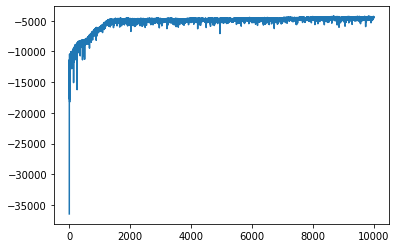

In [19]:
plt.plot(liks)

In [83]:
par = [b0_p,O_p,T_p,mu_p,eta_p]